In [1]:
import pyNUISANCE as pn
import pyProSelecta as pps
import matplotlib.pyplot as plt


In [2]:

class comparison_guru:
    def __init__(self):
        self.rfact = pn.RecordFactory()
        self.input_source_mapping = {} # avoid dup inputs
        self.input_table_mapping = {} # map each input to table list
        self.table_comparisons = {} 

        self.labels = []
        self.tables = {}
        self.comparisons = {}
        self.entries = {}

        self.source_objects = {}
        self.source_mapping = {}
        self.source_weights = {}
        
        self.wfact = pn.WeightCalcFactory()
        self.dial_values = {}
        
    def add(self, yaml_obj, label=None):
        
        table = self.rfact.make_table( yaml_obj )
        if not label: label = table.metadata()["id"]
        
        self.labels.append(label)
        self.entries[label] = yaml_obj
        self.tables[label] = table
        self.comparisons[label] = table.comparison()

        filepath = yaml_obj["filepath"]
        if filepath not in self.source_objects:
            self.source_objects[filepath] = pn.EventSource(filepath)
            self.source_weights[filepath] = self.wfact.make(self.source_objects[filepath], {"neut_cardname": "neut.card"})
            self.source_mapping[filepath] = []

        self.source_mapping[filepath].append( [self.tables[label],self.comparisons[label]] )

    def set_parameter(self, dial, value):
        self.dial_values[dial] = value
        
    def add_hepdata(self, release, table, input_file):
        yaml_obj = {}
        yaml_obj["type"] = "hepdata"
        yaml_obj["filepath"] = input_file
        yaml_obj["release"] = release
        yaml_obj["table"] = table
        self.add(yaml_obj)
        
    def eval(self):

        for weighter in self.source_weights.values():
            weighter.set_parameters(self.dial_values)
            
        for tab, comp in zip(self.tables.values(), 
                             self.comparisons.values()):
            tab.clear(comp)

        for source, associations, weighter in zip(
            self.source_objects.values(),
            self.source_mapping.values(),
            self.source_weights.values()):

            count = 0
            for ev, cvw in source:  
                
                engine_weight = 1.0
                # engine_weight *= weighter.calc_weight(ev)
                    
                for tab, comp in associations:
                    comp.mc.fill_if(tab.select(ev),
                                    tab.project(ev),
                                    cvw * engine_weight * tab.weight(ev))

                count += 1
                if count % 1000 == 0: print(count)
                if count > 100000: break
                    
            for tab, comp in associations:
                tab.finalize(comp, source.fatx()/source.sumw())
            
        chi2 = 0
        for tab, comp in zip(self.tables.values(), 
                             self.comparisons.values()):
            chi2 += tab.likelihood(comp)

        return chi2

    def plot(self):
        for comp in self.comparisons.values():
            plt.title(comp.metadata["id"])
            print(comp.data)
            comp.data.mpl().errorbar(label="Data", color='black', ls='none')
            comp.estimate.mpl().hist(color='green', alpha=0.5, label="MC")  
            plt.legend()
            plt.show()
            

In [3]:
#!cp ../../../runs/NEUT-D2-ANL_77-numu/neutvect.numu.numu_flux.ANL_1977_2horn_rescan.12766.card neut.card
#!cp ../../../runs/NEUT-D2-ANL_77-numu/NEUT.numu.numu_flux.ANL_1977_2horn_rescan.19738.evts.root neut.root

MAKING neut_cardname: neut.card
[WeightCalc:warning]: GENIEReWeightCalc: Passed in IEventSourcePtr not instance of GHEP3EventSource.
Initializing with neut.card
 CRSPATH_ENV: /opt/neut/git_master/share/neut/crsdat
 Reading neut.card as card
 ======= CONFIGURATION FOR INTERACTIONS =======
 Reading neut.card as a card file
Reading bank: NEUT from card file: neut.card
 Parameters not set in nesetfgparams.F                                                                          - only valid for Effective SF
 Parameters not set in nesettarg.F                                                                                      - only valid for Effective SF
 Parameters not set in nrsettarg.F use C12 as default...
Reading bank: NEUT from card file: neut.card
 NECARD : INPUTTED PARAMETER 
 NECARD : CRSPATH= /opt/neut/git_master/share/neut/crsdat/
 NECARD : FERM   =            0
 NECARD : PAUL   =            0
 NECARD : PAUL2p2h =            0
 NECARD : NEFF   =            0
 NECARD : NUCDEXITE

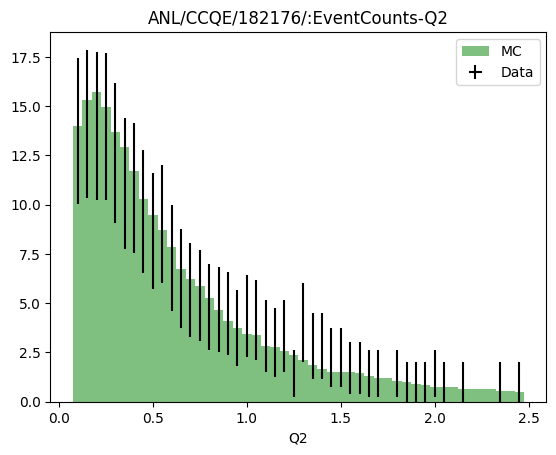

In [4]:
cg = comparison_guru()
cg.add_hepdata("ANL/CCQE/182176/", "EventCounts-Q2", "neut.root")
# cg.set_parameter("AxlFFCCQE", 2)
# cg.set_parameter("MaCCQE", 0.0)
cg.eval()
cg.plot()

 -----------------------
 | bin |  data |   err |
 -----------------------
 |   0 | 13.75 | 3.708 |
 |   1 | 14.11 | 3.756 |
 |   2 |    14 | 3.742 |
 |   3 | 13.96 | 3.737 |
 |   4 | 12.61 | 3.551 |
 |   5 | 11.09 |  3.33 |
 |   6 | 10.86 | 3.296 |
 |   7 | 9.644 | 3.105 |
 |   8 |  8.66 | 2.943 |
 |   9 |     9 |     3 |
 |  10 |  7.28 | 2.698 |
 |  11 | 6.245 | 2.499 |
 |  12 | 5.657 | 2.378 |
 |  13 | 5.385 | 2.321 |
 |  14 | 4.796 |  2.19 |
 |  15 |  4.69 | 2.166 |
 |  16 | 4.472 | 2.115 |
 |  17 | 3.742 | 1.934 |
 |  18 | 4.359 | 2.088 |
 |  19 | 4.123 | 2.031 |
 |  20 | 3.317 | 1.821 |
 |   ... |   ... |
 -----------------------


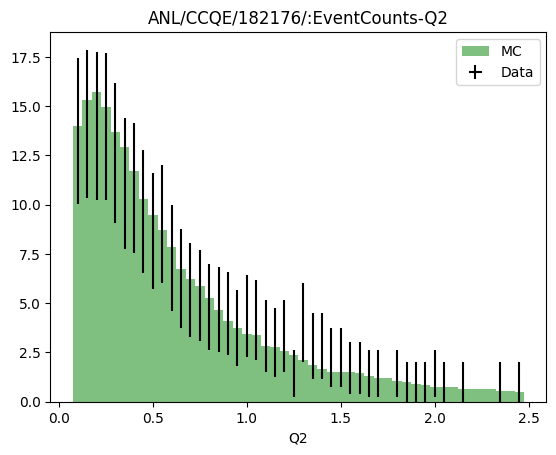

In [5]:
cg.set_parameter("MaCCQE", 0.0)
cg.eval()
cg.plot()

 -----------------------
 | bin |  data |   err |
 -----------------------
 |   0 | 13.75 | 3.708 |
 |   1 | 14.11 | 3.756 |
 |   2 |    14 | 3.742 |
 |   3 | 13.96 | 3.737 |
 |   4 | 12.61 | 3.551 |
 |   5 | 11.09 |  3.33 |
 |   6 | 10.86 | 3.296 |
 |   7 | 9.644 | 3.105 |
 |   8 |  8.66 | 2.943 |
 |   9 |     9 |     3 |
 |  10 |  7.28 | 2.698 |
 |  11 | 6.245 | 2.499 |
 |  12 | 5.657 | 2.378 |
 |  13 | 5.385 | 2.321 |
 |  14 | 4.796 |  2.19 |
 |  15 |  4.69 | 2.166 |
 |  16 | 4.472 | 2.115 |
 |  17 | 3.742 | 1.934 |
 |  18 | 4.359 | 2.088 |
 |  19 | 4.123 | 2.031 |
 |  20 | 3.317 | 1.821 |
 |   ... |   ... |
 -----------------------


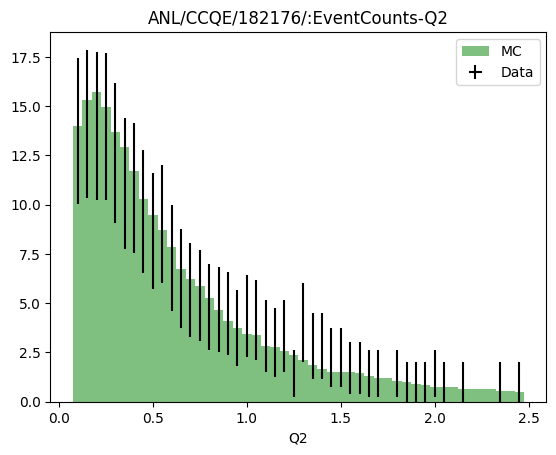

In [6]:
cg.set_parameter("MaCCQE", -1.0)
cg.eval()
cg.plot()

 -----------------------
 | bin |  data |   err |
 -----------------------
 |   0 | 13.75 | 3.708 |
 |   1 | 14.11 | 3.756 |
 |   2 |    14 | 3.742 |
 |   3 | 13.96 | 3.737 |
 |   4 | 12.61 | 3.551 |
 |   5 | 11.09 |  3.33 |
 |   6 | 10.86 | 3.296 |
 |   7 | 9.644 | 3.105 |
 |   8 |  8.66 | 2.943 |
 |   9 |     9 |     3 |
 |  10 |  7.28 | 2.698 |
 |  11 | 6.245 | 2.499 |
 |  12 | 5.657 | 2.378 |
 |  13 | 5.385 | 2.321 |
 |  14 | 4.796 |  2.19 |
 |  15 |  4.69 | 2.166 |
 |  16 | 4.472 | 2.115 |
 |  17 | 3.742 | 1.934 |
 |  18 | 4.359 | 2.088 |
 |  19 | 4.123 | 2.031 |
 |  20 | 3.317 | 1.821 |
 |   ... |   ... |
 -----------------------


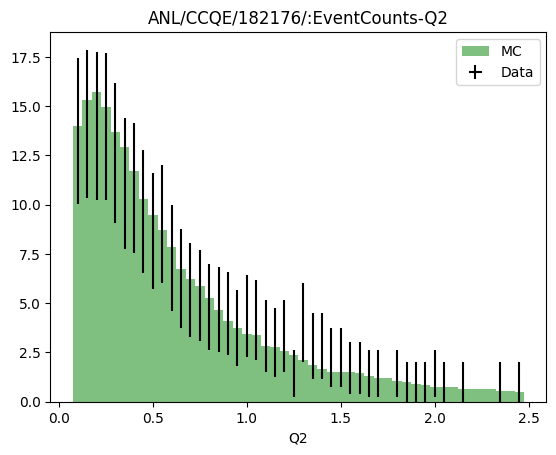

In [7]:
cg.set_parameter("MaCCQE", -1.0)
cg.eval()
cg.plot()

[6.999263697263125]
[6.999263697263125, 6.999263697263125]
[6.999263697263125, 6.999263697263125, 6.999263697263125]
[6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125]
[6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125]
[6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125]
[6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125]
[6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125]
[6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125]
[6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125, 6.999263697263125, 6.

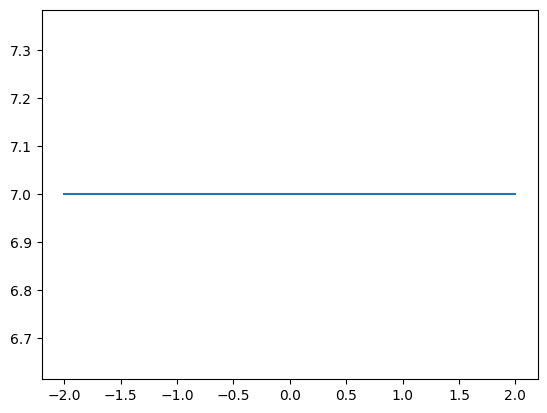

In [8]:
import numpy as np
chi2vals = []
scanvals = np.linspace(-2,2,11)
for val in scanvals:
    cg.set_parameter("MaCCQE", val)
    chi2vals.append(cg.eval())
    print(chi2vals)
import matplotlib.pyplot as plt
plt.plot(scanvals, chi2vals)